<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/master/t81_558_class_10_4_seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in PyTorch**   

* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning, PyTorch [[Video]](https://www.youtube.com/watch?v=CZi5Avp6p1s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* Part 10.2: LSTM-Based Time Series with PyTorch [[Video]](https://www.youtube.com/watch?v=hIQLy5zCgH4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Transformer-Based Time Series with PyTorch [[Video]](https://www.youtube.com/watch?v=NGzQpphf_Vc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_3_transformer_timeseries.ipynb)
* **Part 10.4: Seasonality and Trend** [[Video]](https://www.youtube.com/watch?v=HOkxoLaUF9s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_4_seasonal.ipynb)
* Part 10.5: Predicting with Meta Prophet [[Video]](https://www.youtube.com/watch?v=MzjMVsz0GyA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_5_prophet.ipynb)

# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


Predict demand by removing seasonality. This provides better accuracy than the naive prediction.

In [ ]:
import pandas as pd
import os

df_sales_train = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/sales_train.csv")
df_items = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/items.csv")
df_resturant = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/resturants.csv")

df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce')

Begin by producing a line graph of all sales over the provided 3-year timespan.

In [ ]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## Detrending

Can you see an overall trend in this data? Beyond just the seasonality?

In [ ]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [ ]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## De-Seasoning

Lets remove the seasonality.

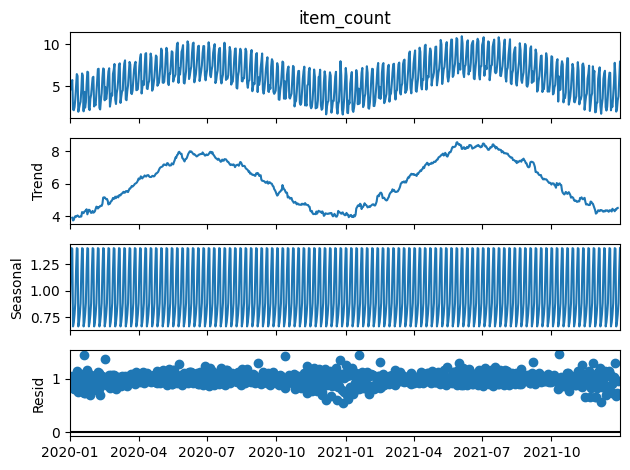

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean()

# extrapolate_trend='freq',
adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative') # , model='additive', period=7

# multiplicative
# additive

adjustment.plot()
pyplot.show()

Notice how the yearly seasonality was detected as the trend? The weekly seasonality was detected as seasonal. Without zooming you cannot see the ups and downs of the individual days of the week.

In [ ]:
adjustment.trend

date
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    3.914286
2020-01-05    3.748571
                ...   
2021-12-27    4.497143
2021-12-28    4.515714
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: trend, Length: 731, dtype: float64

In [ ]:
adjustment.seasonal

date
2020-01-01    0.881087
2020-01-02    1.185819
2020-01-03    1.400388
2020-01-04    1.394790
2020-01-05    0.661817
                ...   
2021-12-27    0.702020
2021-12-28    0.774078
2021-12-29    0.881087
2021-12-30    1.185819
2021-12-31    1.400388
Name: seasonal, Length: 731, dtype: float64

## Resulting Dataset
Lets see the dataset "flattened".

In [ ]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [ ]:
df_adjustment = pd.DataFrame(adjustment.seasonal)
df_adjustment['trend'] = adjustment.trend

df_adjustment

,seasonal,trend
date,,
2020-01-01,0.881087,NaN
2020-01-02,1.185819,NaN
2020-01-03,1.400388,NaN
2020-01-04,1.394790,3.914286
2020-01-05,0.661817,3.748571
...,...,...
2021-12-27,0.702020,4.497143
2021-12-28,0.774078,4.515714
2021-12-29,0.881087,NaN


We will save the adjustment table to a binary pickle form, so we can later reload it exactly as it is. We will make use of this table during day 2.

In [ ]:
df_adjustment.to_pickle("adjustment.pkl")

### Convert All Items
Now that we've estimated seasonality and trend for the average of all items, we must apply this to the individual items.

In [ ]:
df_sales_adj = df_sales_train.merge(df_adjustment,right_index=True,left_on="date")
df_sales_adj.dropna(inplace=True)
df_sales_adj['adjust'] = df_sales_adj.item_count / df_sales_adj.seasonal / df_sales_adj.trend

Compare the individual item plot to the previous example with seasonality still embeded.

In [ ]:
SINGLE_YEAR = 2020

df_sales_single_year = df_sales_adj[df_sales_train['date'].dt.year == SINGLE_YEAR]
df_plot = df_sales_single_year[['date','item_id','adjust']].groupby(['date','item_id']).mean().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['date','adjust','name']]
fig = px.bar(df_plot, x='date', y='adjust',color="name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

<ipython-input-13-eb61c1436bbd>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model.predict(x_train)
cnn_valid_pred = model.predict(x_valid)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_valid_pred)))

In [ ]:
cnn_train_pred2 = cnn_train_pred.flatten() * y_train_seasonal * y_train_trend
cnn_valid_pred2 = cnn_valid_pred.flatten() * y_valid_seasonal * y_valid_trend

print('Train rmse:', np.sqrt(mean_squared_error(y_train_actual, cnn_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid_actual, cnn_valid_pred2)))